In [7]:
import pandas as pd
import requests
import numpy as np
from sklearn.linear_model import LinearRegression 
from datetime import timedelta
from datetime import datetime
import io
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.stats import t
from outliers import smirnov_grubbs as grubbs
from scipy.optimize import curve_fit
import statistics
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
import math
from scipy.signal import convolve
from scipy.interpolate import interp1d
from filterpy.kalman import KalmanFilter
import numpy as np
pd.options.mode.chained_assignment = None
from itertools import combinations 
from scipy.ndimage import gaussian_filter
import matplotlib.patches as mpatches


In [28]:
def st_values(l):
    size = len(l)
    if size >= 25:
        #Normal distribution
        fit = norm.fit(l)
        mean = fit[0]
        std = fit[1]
        dist = 'normal'
    if size < 25 and size >= 5:
        #T-STUDENT DISTR
        fit = t.fit(l)
        mean = fit[1]
        std = fit[2]
        dist = 't'
    if size < 5:
        mean = average(l) if size > 1 else l
        std = np.std(l) if size > 1 else 0
        dist ='n'
    if size == 0:
        return 0,0,0,0,0
    return mean,std,std**2,np.median(l),dist

def average(lst): 
    try:
        return np.mean(lst)
    except:
        return 0
def calculate_values(data):
    data1 = data[data.distance == 1]
    if data1.shape[0] == 0:
        data1 = data[data.distance <= 1]
    
    a = np.mean(data1['rssi_filtered'])
    
    data2 = data[data.distance == 2]
    if data2.shape[0] == 0:
        return -45, 3
    
    n = a - 10*np.log10(2)
    return a,n
    
    
def import_database(wifi = 0):
    #Import database
#     url = "http://btserver-lab10.polito.it/conn_info?csv=1&wifi="+str(wifi)
#     url = "https://drive.google.com/open?id=1A80LjH4X1amgVUBx5Pqqa4BsO92jzII3"
#     s = requests.get(url).content

#     df1 = pd.read_csv(io.StringIO(s.decode('utf-8')), sep=",")
    df1 = pd.read_csv("/home/hugo/Documentos/HumanToHuman/jupyter-experiments/experiment_bt_22_05_2019.csv", sep=",")

    if(wifi == 0):
        #Set up the array 
        df1.columns = ['ID1','ID2','MAC2','rssi','ismobile','timestamp','milliseconds']
        df1['timestamp'] = pd.to_datetime(df1['timestamp'])
        return df1
    else:
        df1.columns = ['ID1','bssid','rssi','timestamp','milliseconds']
        df1['timestamp'] = pd.to_datetime(df1['timestamp'])
        return df1
def load_json_experiments(number):
    #Load Json Data
    with open('experiments.json') as json_data:
        experiments = json.load(json_data)
    experiment = experiments['experiments'][number]
#     print(experiment['experiment'])
    start_dates = experiment['dates']
    try:
        static_devices = experiment['static_devices']
        non_static_devices = experiment['non_static_devices']
    except:
        static_devices = None
    interval = experiment['interval']
    distances = experiment['distances']
    #If there is a position
    try: 
        pos = experiment['position'] 
    except: 
        pos = False
    #In case were there is no static devices (this means there isn't non_static devices)
    if static_devices == None:
        devices = experiment['devices']
        return devices, start_dates, interval, distances, pos
    devices = {'static' : static_devices, 'non_static' : non_static_devices}
    return devices,start_dates,interval, distances, pos

def load_json_devices():
    with open('experiments.json') as json_data:
        experiments = json.load(json_data)
    return experiments['devices']


#BLUETOOTH PART
def proces_data_by_time(data,dates,interval,distances,id1,id2,lim=0,pos = False):
    lim_time = timedelta(seconds = 30)
    count_distances = len(distances)
    duration = timedelta(seconds = interval * (count_distances-1))
    data_frame = pd.DataFrame(columns=data.columns)
    for i, start_date in enumerate(dates):
        start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
        end = start + duration
        start = start 
        #How they see the static devices the non static devices with time
        #Matrix where they see the non_static device
        dfs = data[(data.ID2 == id2) & (data.ID1 == id1) & (data.timestamp >= (start- lim_time) ) & ((data.timestamp) <=(end +lim_time))]
        milliseconds = dfs['milliseconds'].sub(start.timestamp()*1000).values.tolist()
        dfs = dfs.drop('milliseconds',1)
        dfs['milliseconds'] = milliseconds
        if(pos): 
            dfs['pos'] = [i] * dfs.rssi.count()
        data_frame = data_frame.append(dfs, sort = False)
   # print(data_frame.ID1.unique(),data_frame.ID2.unique())
    return pre_process_data(data_frame)
#Find a way to remove noisy data
def pre_process_data(data):
    rssi_values = data['rssi'].values.tolist()
    mean = average(rssi_values)
    std = statistics.stdev(rssi_values) if len(rssi_values) > 1 else 0
    data = data[(mean -2 * std) < data.rssi]
    data = data.sort_values('milliseconds')
#     data_frame = pd.DataFrame(columns=data.columns)
#     for i in range(1,data.rssi.count()):
#         val1 = data.iloc[i]['rssi']
#         val2 = data.iloc[i-1]['rssi']
#         dif = val1-val2
#         if abs(dif) <= np.sqrt(std):
#             data_frame = data_frame.append(data.iloc[i], sort = False)
    return data

#This function is going to calculate the parameters of the line
def linear_regression_params(dataX,datay):
    lm = LinearRegression()
    X = np.array(dataX).reshape(-1,1)
    fit = lm.fit(X,datay)
    m = fit.coef_
    n = fit.intercept_
    r2 = mean_square_error_from_line(dataX,datay,m,n)
    return fit,r2

#Will add a row to the data frame, to the real distances of the experiment
def add_real_distances(data,distances,interval,lim = 0):
    data_frame = pd.DataFrame(columns=data.columns)
    for i,distance in enumerate(distances):
        start_point = i*1000*interval
        end_point = start_point + interval * 1000
        if i == 0:
            start_point = start_point - 1000*lim
        if i == len(distances)-1: 
            end_point = end_point + 1000*lim
        dfs = data[(data.milliseconds >= start_point) & (data.milliseconds < end_point)]
        dfs.loc[:,'distance'] = [distance] * len(dfs['rssi_filtered'].values.tolist())
        data_frame = data_frame.append(dfs, ignore_index = 1, sort = False)
    return data_frame

def mean_square_error_from_line(dataX,dataY,m,n):
    if(len(dataX) == 0 or len(dataY) == 0):
        return
    calculatedY = dataX * m  + n
    return mean_squared_error(dataY,calculatedY)
    
#Should remove the outliers that are out of q1 and q3
def remove_distance_outliers(data,distances):
    data_frame = pd.DataFrame(columns=data.columns)
    for distance in distances:
        data_dist = data[data.distance == distance]
        rssi_dist = data_dist[data_dist.distance == distance]['rssi_filtered'].tolist()
        try:
            rssi_dist.sort()
            q1, q3= np.percentile(rssi_dist,[25,75])
            iqr = q3 - q1
            lower_bound = q1 -(1.5 * iqr) 
            upper_bound = q3 +(1.5 * iqr)
            valid_data = data_dist[(data_dist.rssi >= lower_bound) & (data_dist.rssi <= upper_bound)]
            data_frame = data_frame.append(valid_data , ignore_index = 1, sort = False)
        except:
            continue
    return data_frame
#Function that add the statistics values of the dataset depending of the distance
def add_statistics(data,distances):
    data_frame = pd.DataFrame(columns=data.columns)
    for distance in distances:
        dfs = data[data.distance == distance]
        mean,std,var,median,dist = st_values(dfs['rssi_filtered'].tolist())
        dfs.loc[:,'mean'] = [mean] * len(dfs['rssi_filtered'].values.tolist())
        dfs.loc[:,'std'] = [std] * len(dfs['rssi_filtered'].values.tolist()) 
        dfs.loc[:,'var'] = [var] * len(dfs['rssi_filtered'].values.tolist())
        dfs.loc[:,'median'] = [median] * len(dfs['rssi_filtered'].values.tolist())
        dfs.loc[:,'dist'] = [dist] * len(dfs['rssi_filtered'].values.tolist())
        data_frame = data_frame.append(dfs, ignore_index = 1, sort = False)
    return data_frame
def line(x,m,n):
    return x*m + n
#Function that will create the necessary values to get the line and the score of it
def line_function(fit,x,y = None):
    x_min = min(x)
    x_max = max(x)
    m = fit.coef_
    n = fit.intercept_
#     print(m,n)
    return [x_min,x_max],[line(x_min,m,n),line(x_max,m,n)]
#The model used for 
def distance_by_rssi(x,a,n):
    return np.multiply(np.power(10,-(x-a)/(10*n)))

#Function to represent the data with a boxplot
def get_box_plot(data,distances):
    bx = []
    for distance in distances:
        bx.append(data[data['distance'] == distance]['rssi_filtered'].tolist())
    return bx

#Function that return the fit parameters of the function
def curve_model(data,t = 'rssi'):   
    if(t != 'rssi'):
        d = np.unique(data[[t,'distance']].values, axis = 0)
        x = d[:,0]
        y = d[:,1]
    else:
        x = data[t].values
        y  = data['distance'].values
    
    max_value = max(data['rssi_filtered'].tolist()) 
    min_value = min(data['rssi_filtered'].tolist())
    
    start_x = min(x)
    start_y = max(y)
    min_bounds = (-60,1.2,0)
    max_bounds = (-30,5,1)
    data = data[data.distance >= 1]
    try:
        fit, params  = curve_fit(distance_by_rssi,x,y,p0  = [max_value,4,1], maxfev=10000,bounds = (min_bounds,max_bounds))
    except:
        fit, params  = curve_fit(distance_by_rssi,x,y,p0  = [max_value,4,1], maxfev=10000)
    print(fit)
    return fit,max_value,min_value
    
#Function that calculates the curve with the curve_fit paramters
def curve_values(fit,max_value,min_value):
    arr = np.random.uniform(low = min_value, high=max_value, size=(100,))
    arr.sort()
    dfit = distance_by_rssi(arr,*fit)
    return arr,dfit,fit
#To add a calculated distance to a row
def add_calculated_distance_val(data,fit,name = 'custom_val'):
    a, n = calculate_values(data)
    cal_dist = distance_by_rssi(data['rssi_filtered'].values,a,n)
    data.loc[:,name] = cal_dist.tolist()
    return data
def add_calculated_distance_by_n(data,fit,name = 'calculated_distance'):
    cal_dist = distance_by_rssi(data['rssi_filtered'].values,*fit)
    data.loc[:,name] = cal_dist.tolist()
    return data
def add_custom_calculated_distance(data,max_value,n,name = 'calculated_distance'):
    cal_dist = distance_by_rssi(data['rssi_filtered'].values,max_value,n)
    data.loc[:,name] = cal_dist.tolist()
    return data



#Wifi functions
def proces_wifi_data_by_time(data,dates,interval,distances,id1,id2):
    lim_time = timedelta(seconds = 30)
    count_distances = len(distances)
    duration = timedelta(seconds = interval * (count_distances-1))
    data_frame = pd.DataFrame(columns=data.columns)
    for start_date in start_dates:
        start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
        end = start + duration
        start = start 
        #How they see the static devices the non static devices with time
        #Matrix where they see the non_static device
        dfs = data[((data.ID1 == id1) | (data.ID1 == id2)) & (data.timestamp >= (start- lim_time) ) & ((data.timestamp) <=(end +lim_time))]
        milliseconds = dfs['milliseconds'].sub(start.timestamp()*1000).values.tolist()
        dfs = dfs.drop('milliseconds',1)
        dfs['milliseconds'] = milliseconds
        data_frame = data_frame.append(dfs, sort = False)
    return pre_process_data(data_frame)

def median_filter_data(data,window = 5):
#     data_frame = pd.DataFrame(columns=data.columns)
    rssi_list  = data['rssi'].tolist()
    final_values = []
    k = 0
    while k < len(rssi_list):
        values = []
        for i in range(0,window):
            try:
                values.append(rssi_list[k+i]) 
            except: 
                break
        median = np.median(values)
        cal_value = []
        for i in range(0,window):
            try:
                cal_value = rssi_list[k+i] - (rssi_list[k+i] - median) * 0.2
                final_values.append(cal_value)
            except:
                break
        k = k + window
#     print(len(final_values))
#     print(len(rssi_list))
    data.loc[:,'rssi_filtered'] = final_values
    return data

def gaussian_filter_data(data):
    rssi_values = data['rssi']
    blurred = gaussian_filter(rssi_values,sigma = np.std(rssi_values))
    data.loc[:,'rssi_filtered'] = blurred
    return data


def get_value_from_distances(data,f):
    if f == None:
        return data['distance'], data['rssi_filtered']
    distances = data.distance.unique()
    rssi_values = []
    for distance in distances:
        val = f(data[data.distance == distance]['rssi_filtered'].tolist())
        rssi_values.append(val)
    return distances,rssi_values

def filter_data(data,fil=None):
    if fil == None:
        data.loc[:,'rssi_filtered'] = data['rssi']
        return data
    data
    return fil(data)
    
def handle_data(data,device1,device2,start_dates,interval,distances1,pos = False):
    distances = distances1
    try:
        reverse = device1['reverse']
    except:
        reverse = False
        try:
            reverse = device2['reverse']
        except:
            reverse = False
    #Process all the data
    if(reverse):
        distances.reverse()  
    treated_data = proces_data_by_time(data,start_dates,interval,distances,device1['id'],device2['id'], lim =30, pos = pos)
    treated_data =  filter_data(treated_data,gaussian_filter_data)
    treated_data = add_real_distances(treated_data,distances,interval,lim = 30)
    treated_data = remove_distance_outliers(treated_data,distances)
    if(reverse):
        distances.reverse()
    #treated_data = median_filter_data(treated_data,window = 10)
    treated_data = add_statistics(treated_data,distances)
    return treated_data
    

In [22]:
def plot_rssi_by_time(data,device1,device2,rssi='rssi'):
    #Line regression
    lm,score = linear_regression_params(data['milliseconds'].tolist(),data['rssi'].tolist())
    x_line,y_line = line_function(lm,data['milliseconds'],data['rssi_filtered'])
    fig = plt.plot()
    plt.title("RSSI by time: " + device2['name'] + " seen by " + device1['name'])
    plt.xlabel('Milliseconds')
    plt.ylabel('dbm')
    p1 = plt.scatter(data['milliseconds'],data[rssi])
#     p2 = plt.scatter(data1['milliseconds'],data1['rssi_filtered'])
    p2 = plt.plot(x_line,y_line,label='r2: '+str(round(score,3)),color ="C1")
    plt.legend(loc='best')
    plt.show()
    return lm


def plot_every_dbm_meter(data,devices,fun=None,rssi='rssi_filtered',title="default"):
    tuples = combinations(devices_ids,2)
    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel('m')
    plt.ylabel('dbm')
    plt.title(title)
    for device1,device2 in list(tuples):
        data1 = data[(data.ID1 == device1['id']) & (data.ID2 == device2['id'])]
        data2 = data[(data.ID2 == device1['id']) & (data.ID2 == device1['id'])]
        if(data1.rssi.count() > 0):
            distance,rssi = get_value_from_distances(data1,fun)
            plt.scatter(distance,rssi, label = device1['name'] + "-" + device2['name'])
        if(data2.rssi.count() > 0):
            distance,rssi = get_value_from_distances(data2,fun)
            plt.scatter(distance,rssi, label = device2['name'] + "-" + device1['name'])
    plt.legend(loc = 'best')
    plt.show()

def plot_rssi_by_distance(data,device1,device2,rssi ='rssi'):
    distances = data.distance.unique()
#     print(data)
#     bx = get_box_plot(data,distances)
#     fit_x, fit_y, fit = curve_values(*curve_model(data)) 
#     fit_x_m, fit_y_m, fit_m  = curve_values(*curve_model(data,t = 'mean')) 
#     fit_x_median, fit_y_median, fit_median = curve_values(*curve_model(data,t = 'median')) 
    
    max_val = max(data['rssi_filtered'].tolist())
    min_val = min(data['rssi_filtered'].tolist())
    a,n = calculate_values(data,max_val,min_val)
    
    fit_x, fit_y, fit_val = curve_values()
    
    fit_x_median, fit_y_median, fit_median = curve_values(data, t='') 
    data_1_meter = data[(data.distance == 1)]
    print('Mean: ' + str(np.mean(data_1_meter.rssi.tolist())))
    print('Median: ' + str(np.median(data_1_meter.rssi.tolist())))
    try:
        print('Max: ' + str(max(data_1_meter.rssi.unique())))
    except:
        pass
    
    try:
        print('Min: ' + str(min(data_1_meter.rssi.unique())))
    except:
        pass
    
    plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
    fig = plt.plot()
    plt.title("Distance by RSSI: "+ device2['name'] + " seen by " + device1['name'])
    plt.xlabel('m')
    plt.ylabel('dbm')
    p1 = plt.scatter(data['distance'],data[rssi])
# plt.plot(fit_y,fit_x, color = "C1", label ="values")
    plt.plot(fit_y_m,fit_x_m, color = "C2", label="mean")
    plt.plot(fit_y_median,fit_x_median, color = "C3", label ="median")

#     plt.boxplot(bx,positions=distances,vert=False)
    plt.boxplot(bx,positions=distances,widths = 0.1)
    plt.legend(loc ='best')
    plt.show()
    
    #Plot errors
    
    
#     #Plot calculated distance vs real distance
#     #With all the values
#     data = add_calculated_distance(data,fit)
#     lm,score = linear_regression_params(data['distance'].tolist(),data['calculated_distance'].tolist())
#     x_line, y_line = line_function(lm,data['distance'])
#     err = round(mean_squared_error(data['distance'], data['calculated_distance']),3)
#     fig = plt.plot()
#     plt.title('With all values: '+ device2 + " seen by " + device1)
#     plt.xlabel('Real distance (m)')
#     plt.ylabel('Calculated Distance (m)')
#     p1 = plt.scatter(data['distance'],data['calculated_distance'], label = "r2: " + str(round(score,3)))
#     #p2 = plt.plot([0,max(data1['distance'].values)],[0,max(data1['distance'].values)],color='C1')
#     p3 = plt.plot(x_line,y_line)#,label='r2: '+str(round(score,3)),color ="C2")
#     plt.legend(loc = 'best')
#     plt.show()

#     #With the mean values
#     data = add_calculated_distance(data,fit_m,'calculated_distance_by_mean')
#     lm,score = linear_regression_params(data['distance'].tolist(),data['calculated_distance_by_mean'].tolist())
#     x_line, y_line = line_function(lm,data['distance'])
#     err = round(mean_squared_error(data['distance'], data['calculated_distance_by_mean']),3)
#     fig = plt.plot()
#     plt.title('By mean: '+ device2 + " seen by " + device1)
#     plt.xlabel('Real distance (m)')
#     plt.ylabel('Calculated Distance (m)')
#     p1 = plt.scatter(data['distance'],data['calculated_distance_by_mean'],label = "r2: " + str(round(score,3)))
#     #p2 = plt.plot([0,max(data1['distance'].values)],[0,max(data1['distance'].values)],color='C1')
#     p3 = plt.plot(x_line,y_line)#,label='r2: '+str(round(score,3)),color ="C2")
#     plt.legend(loc = 'best')
#     plt.show()

    #With the median values
    data = add_calculated_distance(data,fit_median,'calculated_distance_by_median')
    lm,score = linear_regression_params(data['distance'].tolist(),data['calculated_distance_by_median'].tolist(),)
#     err = round(mean_squared_error(data1['distance'], data1['calculated_distance_by_median']),3)
    x_line, y_line = line_function(lm,data['distance'])
    fig = plt.plot()
    plt.title("By median:" + device2['name'] + " seen by " + device1['name'])
    plt.xlabel('Real distance (m)')
    plt.ylabel('Calculated Distance (m)')
    p1 = plt.scatter(data['distance'],data['calculated_distance_by_median'],label = "r2: " + str(round(score,3)))
    #p2 = plt.plot([0,max(data1['distance'].values)],[0,max(data1['distance'].values)],color='C1')
    p3 = plt.plot(x_line,y_line)#label='r2: '+str(round(score,3)),color ="C2")
    plt.legend(loc = 'best')
    plt.show()
    
#     data = data[(data.distance <= 3) & (data.distance >= 0)]

#     data = add_custom_calculated_distance(data,max(data_1_meter.rssi.unique()),fit[1],1,fit[3],'calculated_max_value')
#     lm,score = linear_regression_params(data['distance'].tolist(),data['calculated_max_value'].tolist(),)
#     x_line, y_line = line_function(lm,data['distance'])
#     fig = plt.plot()
#     plt.title("By Calculated:" + device2 + " seen by " + device1)
#     plt.xlabel('Real distance (m)')
#     plt.ylabel('Calculated Distance (m)')
#     p1 = plt.scatter(data['distance'],data['calculated_max_value'],label = "r2: " + str(round(score,3)))
#     p3 = plt.plot(x_line,y_line)
#     plt.legend(loc = 'best')
#     plt.show()

In [23]:
#Test
dataBT = import_database()

In [24]:

# # Saving main parameters of the experiment (when it is)
devices_ids = load_json_devices()
def device_data(dataBT,filter_exp):
    i = 0
    data = None
    while True:
        #Search over all the experiments
        try:
            devices, start_dates, interval, distances, pos = load_json_experiments(i)
        except:
            break
        if not i in filter_exp:
            i = i +1
            continue    
        if type(devices) is dict:
            for device1 in devices['static']:
                for device2 in devices['non_static']:
                    if device1['id'] == device2['id']: 
                        continue
                    new_data1 = handle_data(dataBT,device1,device2,start_dates,interval,distances,pos)
                    new_data2 = handle_data(dataBT,device2,device1,start_dates,interval,distances,pos)
                    try:
                        data = data.append(new_data1,sort=False)
                    except:
                        data = new_data1
                    data = data.append(new_data2,sort=False)
                    
                    
                    plot_rssi_by_distance(data,device1,device2,rssi='rssi_filtered')
                    #print(data)
        else:
            for device1 in devices:
                for device2 in devices:
                    if device1['id'] == device2['id']: 
                        continue
                    new_data1 = handle_data(dataBT,device1,device2,start_dates,interval,distances,pos)
                    new_data2 = handle_data(dataBT,device2,device1,start_dates,interval,distances,pos)
                    try:
                        data = data.append(new_data1,sort=False)
                    except:
                        data = new_data1
                    data = data.append(new_data2,sort=False)     
                    
                    plot_rssi_by_distance(data,device2,device1,rssi='rssi_filtered')
        #                 print(data)
        i = i+1
    try:
        data = data.drop_duplicates()
    except:
        pass
    return data



In [29]:
for number in range(11):
    if number in [4,5,6]:
        continue
    i = []
    i.append(number)
    data = device_data(dataBT,i)

ValueError: invalid number of arguments

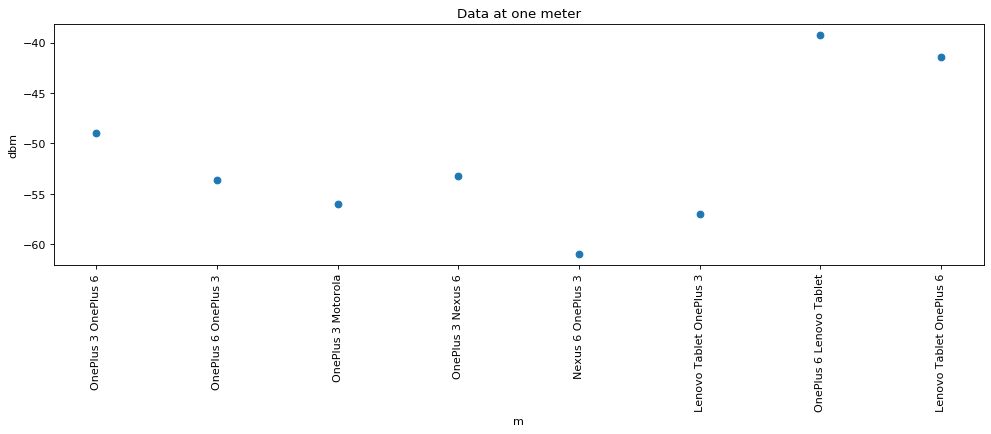

In [13]:
devices_ids = load_json_devices()
data = device_data(dataBT,range(0,12))

    
    
f = np.mean
tuples = list(combinations(devices_ids,2))
data_to_plot= pd.DataFrame()
for device1,device2 in list(tuples):
    data_to_plot1 = data[(data.ID1 == device1['id']) & (data.ID2 == device2['id']) & (data.distance == 1)] 
    data_to_plot2 = data[(data.ID1 == device2['id']) & (data.ID2 == device1['id']) & (data.distance == 1)]
    
    val1 = f(data_to_plot1['rssi'])
    val2 = f(data_to_plot2['rssi'])
    
    if type(val1) != float:
        data_to_plot = data_to_plot.append([{"tuple" : device1['name'] + " " + device2['name'], "val": f(data_to_plot1['rssi'])}])
    if type(val2) != float:
        data_to_plot = data_to_plot.append([{"tuple" : device2['name'] + " " + device1['name'], "val": f(data_to_plot2['rssi'])}])

plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
fig = plt.plot()
plt.title("Data at one meter")
plt.xlabel('m')
plt.ylabel('dbm')
p1 = plt.scatter(data_to_plot['tuple'],data_to_plot['val'])
plt.xticks(rotation=90)
# plt.plot(fit_y,fit_x, color = "C1", label ="values")
plt.show()

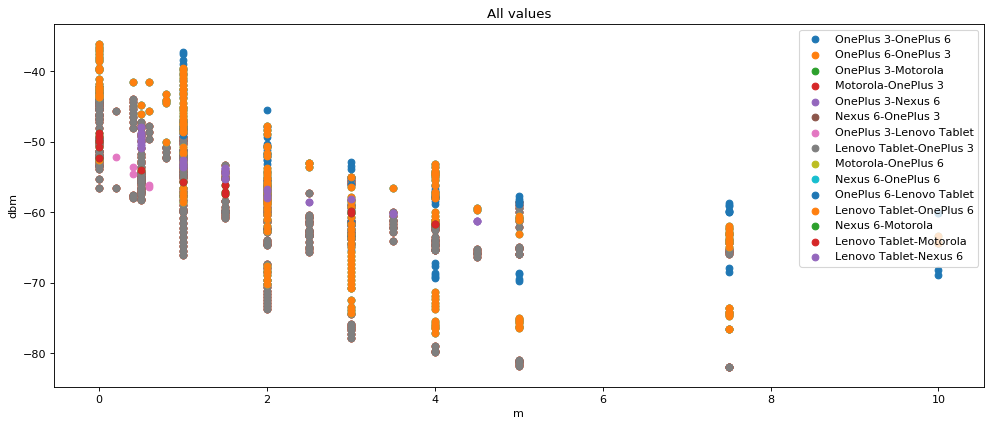

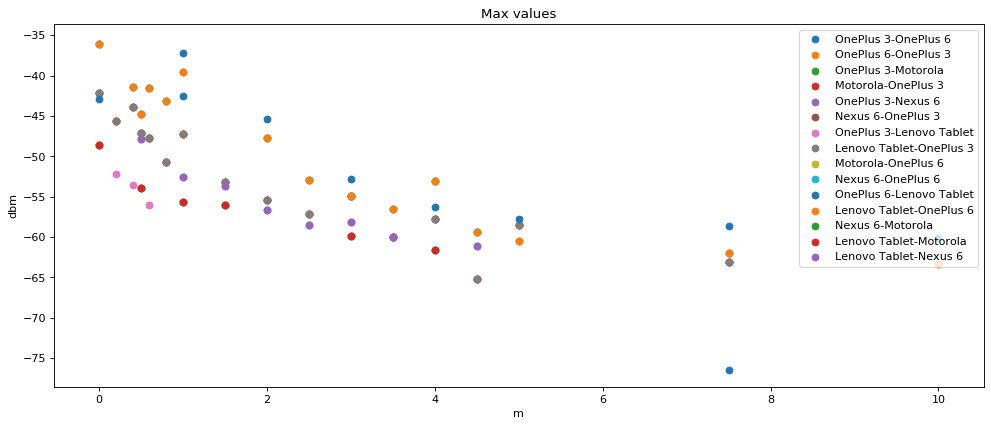

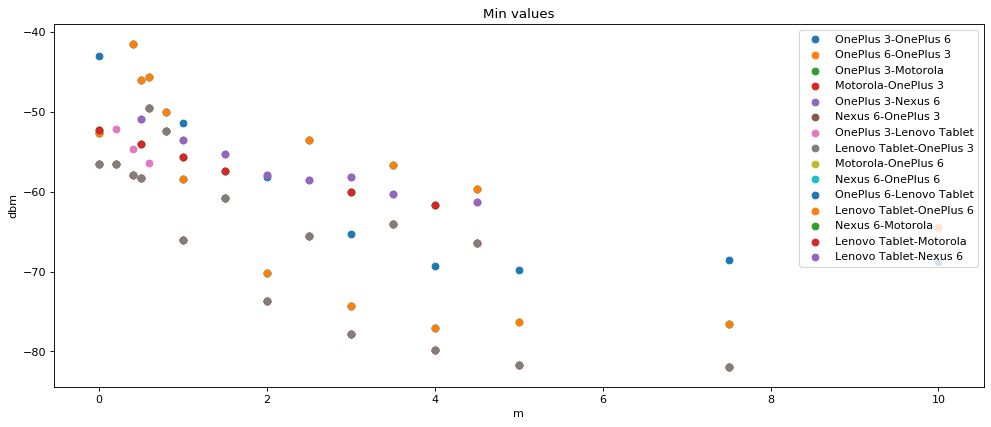

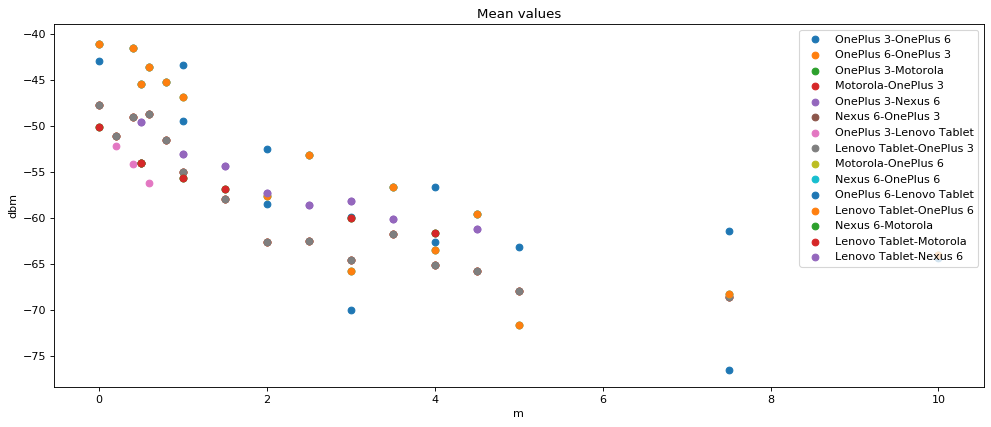

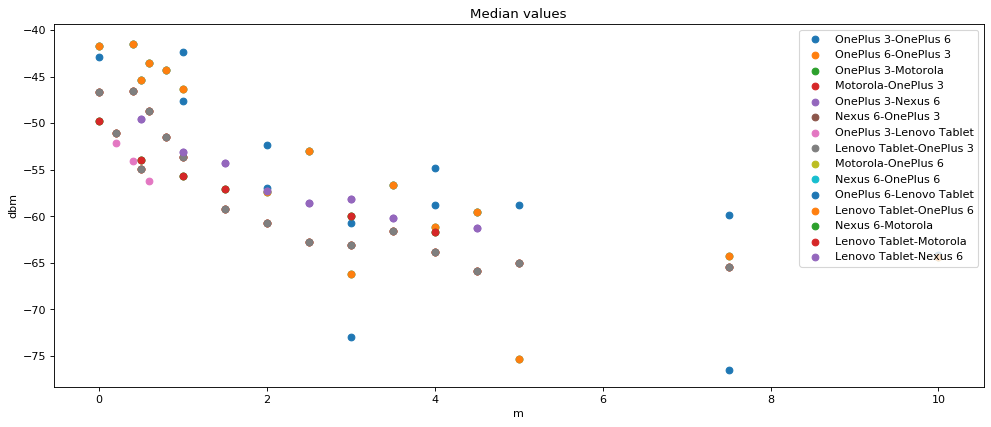

In [14]:
data = device_data(dataBT,[0,1,2,3,4,5,6,7,8,9,10])
plot_every_dbm_meter(data,devices_ids,title="All values")
plot_every_dbm_meter(data,devices_ids,fun = max,title="Max values")  
plot_every_dbm_meter(data,devices_ids,fun = min,title="Min values") 
plot_every_dbm_meter(data,devices_ids,fun = np.mean,title = "Mean values") 
plot_every_dbm_meter(data,devices_ids,fun = np.median,title = "Median values")